In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import jieba.posseg as psg

In [2]:
# 加载评论数据
reviews = pd.read_excel('jd_手机评论.xlsx')
reviews

,昵称1,内容1,评论时间,产品类型
0,u***d,该用户觉得商品不错,2023-01-05 15:10:00,尊贵黑【8+256GB】
1,****i,手机收到了试了试挺好的，值得购买,2023-01-05 13:42:00,尊贵黑【8+256GB】
2,冰***-,挺好的,2023-01-05 00:31:00,尊贵黑【8+128GB】
3,舒***亿,发货速度快，质量挺好的，和卖家描述的一样，非常满意,2023-01-05 00:00:00,尊贵黑【8+128GB】
4,****8,宝贝收到非常喜欢 外形外观：颜色非常漂亮 运行速度：非常快 拍照效果：拍照清晰 待机时间：待...,2023-01-04 22:36:00,晴川蓝【8+256GB】
...,...,...,...,...
219,Y***d,图便宜给孩子买个上网课用了。但是质量太差了 ，开不了机不说。跟孩子视频听不见声音。关键客服就...,2022-12-19 20:02:00,尊贵黑【8+256GB】
220,****c,便宜好用！,2022-11-03 20:23:00,初雪水晶【8+256GB】
221,u***h,手机流畅,2022-11-05 19:29:00,初雪水晶【8+256GB】
222,爱***猫,手感不错,2022-11-03 20:40:00,初雪水晶【8+256GB】


In [3]:
# 统计重复数据
reviews[['内容1','昵称1']].duplicated().sum()

4

In [4]:
# 评论去重
reviews = reviews[['内容1','昵称1']].drop_duplicates()
reviews

,内容1,昵称1
0,该用户觉得商品不错,u***d
1,手机收到了试了试挺好的，值得购买,****i
2,挺好的,冰***-
3,发货速度快，质量挺好的，和卖家描述的一样，非常满意,舒***亿
4,宝贝收到非常喜欢 外形外观：颜色非常漂亮 运行速度：非常快 拍照效果：拍照清晰 待机时间：待...,****8
...,...,...
218,老人用，还可以,****H
220,便宜好用！,****c
221,手机流畅,u***h
222,手感不错,爱***猫


In [5]:
reviews.reset_index(drop=True,inplace=True)

In [6]:
# 去掉评论中的数字、字母，以及“京东”“京东商城”
content = reviews['内容1']
# 编译匹配模式
pattern = re.compile('[a-zA-Z0-9]|京东|手机|该用户觉得商品不错|京东商城')
# re.sub用于替换字符串中的匹配项
content = content.apply(lambda x : pattern.sub('',x))  #将字符串中的空格去除

In [7]:
content

0                                                       
1                                         收到了试了试挺好的，值得购买
2                                                    挺好的
3                              发货速度快，质量挺好的，和卖家描述的一样，非常满意
4      宝贝收到非常喜欢 外形外观：颜色非常漂亮 运行速度：非常快 拍照效果：拍照清晰 待机时间：待...
                             ...                        
215                                              老人用，还可以
216                                                便宜好用！
217                                                   流畅
218                                                 手感不错
219                                          打游戏发热，不是理想型
Name: 内容1, Length: 220, dtype: object

对文本进行分词，然后对每个分词结果中的词语和词性标注进行遍历，最终构建一个二维列表，其中每个子列表包含一个词语和对应的词性标注。

In [8]:
# 自定义简单的分词函数
worker = lambda s : [[x.word,x.flag] for x in psg.cut(s)]   # 单词与词性
seg_word = content.apply(worker)
seg_word

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\admin\AppData\Local\Temp\jieba.cache
Loading model cost 0.589 seconds.
Prefix dict has been built successfully.


0                                                     []
1      [[收到, v], [了, ul], [试了试, v], [挺, d], [好, a], [...
2                              [[挺, d], [好, a], [的, uj]]
3      [[发货, n], [速度, n], [快, a], [，, x], [质量, n], [挺...
4      [[宝贝, nr], [收到, v], [非常, d], [喜欢, v], [ , x], ...
                             ...                        
215           [[老人, n], [用, p], [，, x], [还, d], [可以, c]]
216                    [[便宜, a], [好, a], [用, p], [！, x]]
217                                            [[流畅, a]]
218                                   [[手感, n], [不错, a]]
219    [[打游戏, l], [发热, v], [，, x], [不是, c], [理想, n], ...
Name: 内容1, Length: 220, dtype: object

In [9]:
# 将词语转化为数据框形式，一列是词，一列是词语所在的句子id，最后一列是词语在该句子中的位置
 # 每一评论中词的个数
n_word = seg_word.apply(lambda x: len(x)) #计算每个评论中词语的个数，并将结果保存在名为n_word的Series中。

# 构造词语所在的句子id
n_content = [[x+1]*y for x,y in zip(list(seg_word.index), list(n_word))]

# 将嵌套的列表展开，作为词所在评论的id
index_content = sum(n_content, [])    # []指定相加的参数


In [10]:
seg_word = sum(seg_word,[])
# 词
word = [x[0] for x in seg_word]
# 词性
nature = [x[1] for x in seg_word]

In [11]:
# 构造数据框
result = pd.DataFrame({'index_content': index_content,
                      'word' : word,
                      'nature': nature
                      })
result

,index_content,word,nature
0,2,收到,v
1,2,了,ul
2,2,试了试,v
3,2,挺,d
4,2,好,a
...,...,...,...
3109,220,发热,v
3110,220,，,x
3111,220,不是,c
3112,220,理想,n


In [12]:
# 删除标点符号
result = result[result['nature'] != 'x']
result

,index_content,word,nature
0,2,收到,v
1,2,了,ul
2,2,试了试,v
3,2,挺,d
4,2,好,a
...,...,...,...
3108,220,打游戏,l
3109,220,发热,v
3111,220,不是,c
3112,220,理想,n


In [13]:
# 删除停用词
# 加载停用词
stop_path = open(r'stoplist.txt','r',encoding='utf-8')
stop = [x.replace('\n','') for x in stop_path.readlines()]
# 得到非停用词序列
word = list(set(word) - set(stop)) #与停用词集合取差，得到 word 中不包含停用词的词语。

# 判断表格中的单词列是否在非停用词列中
result = result[result['word'].isin(word)] #筛选出不包含停用词的结果。
result

,index_content,word,nature
0,2,收到,v
2,2,试了试,v
7,2,值得,v
8,2,购买,v
12,4,发货,n
...,...,...,...
3107,219,不错,a
3108,220,打游戏,l
3109,220,发热,v
3112,220,理想,n


In [14]:
# 构造各词在评论中的位置列
#统计每个分组中的词语数量，得到一个由词语数量组成的列表n_word。
n_word = list(result.groupby(by=['index_content'])['index_content'].count())

# 根据n_word中的词语数量，为每个评论构造一个序列列表，存储在index_word中。每个评论的位置序列表示该评论中词语的位置索引。
index_word = [list(np.arange(0,x)) for x in n_word]

# 将嵌套的index_word列表展开，即将所有评论的位置序列合并为一个一维列表，存储在index_word中。
index_word = sum(index_word,[])

# 将位置序列列表index_word添加为result数据表的新列，命名为index_word，表示各词在评论中的位置。
result['index_word'] = index_word

# 重新设置result数据表的索引，将索引重新编号，并在原地修改数据表。
result.reset_index(drop=True,inplace=True)
result

C:\Users\admin\AppData\Local\Temp\ipykernel_11284\1210973358.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['index_word'] = index_word


,index_content,word,nature,index_word
0,2,收到,v,0
1,2,试了试,v,1
2,2,值得,v,2
3,2,购买,v,3
4,4,发货,n,0
...,...,...,...,...
1330,219,不错,a,1
1331,220,打游戏,l,0
1332,220,发热,v,1
1333,220,理想,n,2


In [15]:
# 提取含名词的评论的句子id
# 选择取值为名词（'n'）的行，然后将index_content列提取出来。使用unique()函数得到含有名词的评论的句子id并将其存储在ind列表中。
ind = result[[x == 'n' for x in result['nature']]]['index_content'].unique()

# 提取评论
# 将result数据表中index_content列中的值与ind列表中的值进行匹配，筛选出含有名词的评论，并将结果覆盖原始的result数据表。
result = result[result['index_content'].isin(ind)]

# 重置索引
result.reset_index(drop=True,inplace=True)
result

,index_content,word,nature,index_word
0,4,发货,n,0
1,4,速度,n,1
2,4,质量,n,2
3,4,卖家,n,3
4,4,描述,v,4
...,...,...,...,...
1257,219,不错,a,1
1258,220,打游戏,l,0
1259,220,发热,v,1
1260,220,理想,n,2


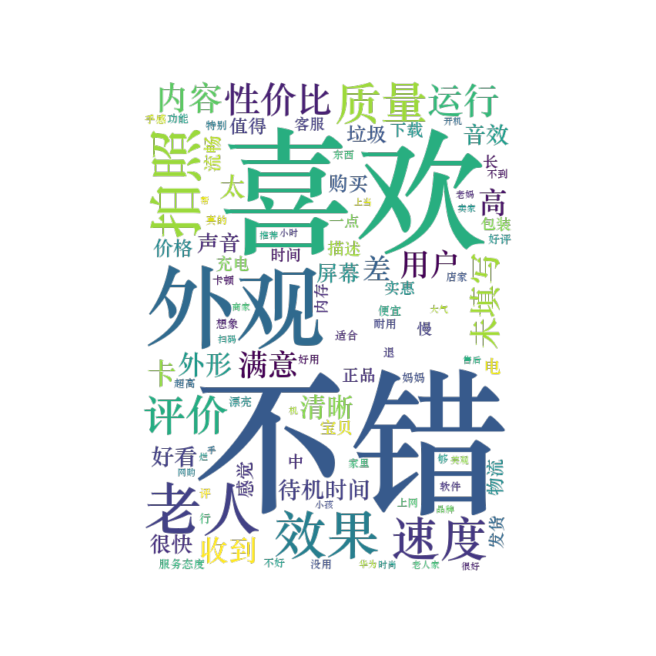

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 按word分组统计数目
frequencies = result.groupby(by = ['word'])['word'].count()
# 按数目降序排序
frequencies = frequencies.sort_values(ascending=False)

# 读取背景图片
background_image = Image.open('手机图片.jpg') # 替换'your_image_path.jpg'为你指定的图片路径
background_array = np.array(background_image)

# 创建词云对象，并设置背景图
wordcloud = WordCloud(font_path="C:\Windows\Fonts\STZHONGS.ttf",
                      max_words=100,
                      background_color=None,
                      mode='RGBA',
                      mask=background_array,
                      contour_width=0,
                      prefer_horizontal=0.99)

# 生成词云图
my_wordcloud = wordcloud.generate_from_frequencies(frequencies)
# 设置matplotlib图像大小和分辨率
plt.figure(figsize=(6, 4), dpi=200)
# 绘制词云图
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [17]:
# 将结果写出
result.to_csv("word.csv", index = False, encoding = 'utf-8')

### 正负面情感词评价词合并

In [18]:
# 读入正负面评论情感词表
word = pd.read_csv('word.csv',header=0)
# 读入正面、负面情感评价词
pos_comment = pd.read_csv(r'正面评价词语（中文）.txt', header=None
                          # ,sep="\n"
                          , 
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv(r'负面评价词语（中文）.txt', header=None
                          # ,sep="\n"
                          , 
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv(r'正面情感词语（中文）.txt', header=None
                          # ,sep="\n"
                          , 
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv(r'负面情感词语（中文）.txt', header=None
                          # ,sep="\n"
                          , 
                          encoding = 'utf-8', engine='python')

# 合并情感词与评价词
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])
# 正负面情感词表中相同的词语
intersection = positive & negative  
# 去掉相同的词
positive = list(positive - intersection)
negative = list(negative - intersection)

# 正面词语赋予初始权重1，负面词语赋予初始权重-1
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)})
posneg = positive.append(negative)

C:\Users\admin\AppData\Local\Temp\ipykernel_11284\2471711034.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posneg = positive.append(negative)


### 合并分词结果与情感词

In [19]:
# 将分词结果与正负面情感词表合并，定位情感词
data_posneg = pd.merge(left=word,right=posneg,on='word',how='left')
# 先按评论id排序，再按在评论中的位置排序
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])
data_posneg

,index_content,word,nature,index_word,weight
0,4,发货,n,0,NaN
1,4,速度,n,1,NaN
2,4,质量,n,2,NaN
3,4,卖家,n,3,NaN
4,4,描述,v,4,NaN
...,...,...,...,...,...
1257,219,不错,a,1,NaN
1258,220,打游戏,l,0,NaN
1259,220,发热,v,1,NaN
1260,220,理想,n,2,NaN


In [20]:
# 根据情感词前面两个位置的词语是否存在否定词或双层否定词对情感值进行修正
# 载入否定词表
notdict = pd.read_csv(r'not.csv')
# 处理否定修饰词
# 构造新列，作为经过否定词修正后的情感值
data_posneg['amend_weight'] = data_posneg['weight']  #在 data_posneg 数据框中新增一列初始值等于 "weight" 列的值，用于存储经过否定词修正后的情感值。
data_posneg['id'] = np.arange(0, len(data_posneg)) #新增一列 "id"，该列包含从 0 到数据框长度的整数，用于标识每个词语的唯一ID。
# 只保留有情感值的词语
only_inclination = data_posneg.dropna()  #删除 data_posneg 数据框中含有缺失情感值的行，生成名为 only_inclination 的新数据框。
# 修改索引
only_inclination.index = np.arange(0, len(only_inclination)) #重新设置索引
only_inclination

,index_content,word,nature,index_word,weight,amend_weight,id
0,4,满意,v,5,1.0,1.0,5
1,5,喜欢,v,2,1.0,1.0,8
2,9,高,a,4,-1.0,-1.0,59
3,10,高,a,1,-1.0,-1.0,61
4,10,高,a,4,-1.0,-1.0,64
...,...,...,...,...,...,...,...
90,194,喜欢,v,2,1.0,1.0,1194
91,195,很快,d,0,1.0,1.0,1195
92,201,喜欢,v,1,1.0,1.0,1224
93,206,喜欢,v,3,1.0,1.0,1238


In [21]:
index = only_inclination['id']
for i in np.arange(0, len(only_inclination)):
    # 提取第i个情感词所在的评论
    # 提取 data_posneg 数据框中与当前情感词所在评论相同的所有行，存储在 review 变量中。
    review = data_posneg[data_posneg['index_content'] == only_inclination['index_content'][i]]  
    # 修改索引
    review.index = np.arange(0, len(review)) #重新设置索引
    # 第i个情感值在该文档的位置
    affective = only_inclination['index_word'][i]  #获取情感词在当前评论中的位置，存储在 affective 变量中。
    if affective == 1:        #判断情感词是否在评论中的第一个位置。
        # 情感词前面的单词是否在否定词表
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])
        if ne == 1:    #判断情感词前面的单词是否在否定词表 notdict 中，如果是，则对该情感词的情感权重取负值，以实现否定修正。
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]          
    elif affective > 1: #判断情感词是否在评论中的第二个位置及之后。
        # 判断情感词前面两个位置的词语是否至少有一个在否定词表 notdict 中，如果是，则对该情感词的情感权重取负值，以实现否定修正。
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1, affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -data_posneg['weight'][index[i]]
            
#在执行以上步骤后，only_inclination['amend_weight'] 列中将包含修正后的情感值。

In [22]:
only_inclination

,index_content,word,nature,index_word,weight,amend_weight,id
0,4,满意,v,5,1.0,1.0,5
1,5,喜欢,v,2,1.0,1.0,8
2,9,高,a,4,-1.0,-1.0,59
3,10,高,a,1,-1.0,-1.0,61
4,10,高,a,4,-1.0,-1.0,64
...,...,...,...,...,...,...,...
90,194,喜欢,v,2,1.0,1.0,1194
91,195,很快,d,0,1.0,1.0,1195
92,201,喜欢,v,1,1.0,1.0,1224
93,206,喜欢,v,3,1.0,1.0,1238


In [23]:
only_inclination.isnull().sum()

index_content    0
word             0
nature           0
index_word       0
weight           0
amend_weight     0
id               0
dtype: int64

In [24]:
# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],as_index=False)['amend_weight'].sum()
# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]
emotional_value.reset_index(drop=True,inplace=True)
emotional_value

,index_content,amend_weight
0,4,1.0
1,5,1.0
2,9,-1.0
3,10,-1.0
4,16,2.0
...,...,...
67,194,2.0
68,195,1.0
69,201,1.0
70,206,1.0


In [25]:
# 给情感值大于0的赋予评论类型pos，小于0的赋予neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'
# 查看情感分析的结果
result = pd.merge(left=word,right=emotional_value,on='index_content',how='right')
result

C:\Users\admin\AppData\Local\Temp\ipykernel_11284\1849793864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
C:\Users\admin\AppData\Local\Temp\ipykernel_11284\1849793864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'


,index_content,word,nature,index_word,amend_weight,a_type
0,4,发货,n,0,1.0,pos
1,4,速度,n,1,1.0,pos
2,4,质量,n,2,1.0,pos
3,4,卖家,n,3,1.0,pos
4,4,描述,v,4,1.0,pos
...,...,...,...,...,...,...
619,206,很好,d,2,1.0,pos
620,206,喜欢,v,3,1.0,pos
621,208,性价比,n,0,-1.0,neg
622,208,高,a,1,-1.0,neg


In [26]:
# 去重
result = result[['index_content', 'a_type']].drop_duplicates() 
result

,index_content,a_type
0,4,pos
6,5,pos
26,9,neg
31,10,neg
41,16,pos
...,...,...
603,194,pos
606,195,pos
613,201,pos
617,206,pos


In [27]:
result.groupby('a_type')['index_content'].count()

a_type
neg    25
pos    47
Name: index_content, dtype: int64

In [28]:
len(content)-25-47

148

基本可以确定的好评数47个，差评数25个,未能分辨148个

In [29]:
# 提取正负面评论信息
# 得到正面评论与负面评论对应的索引
ind_pos = list(emotional_value[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value[emotional_value['a_type'] == 'neg']['index_content'])
# 得到正面评论与负面评论
posdata = word[[i in ind_pos for i in word['index_content']]]
negdata = word[[i in ind_neg for i in word['index_content']]]

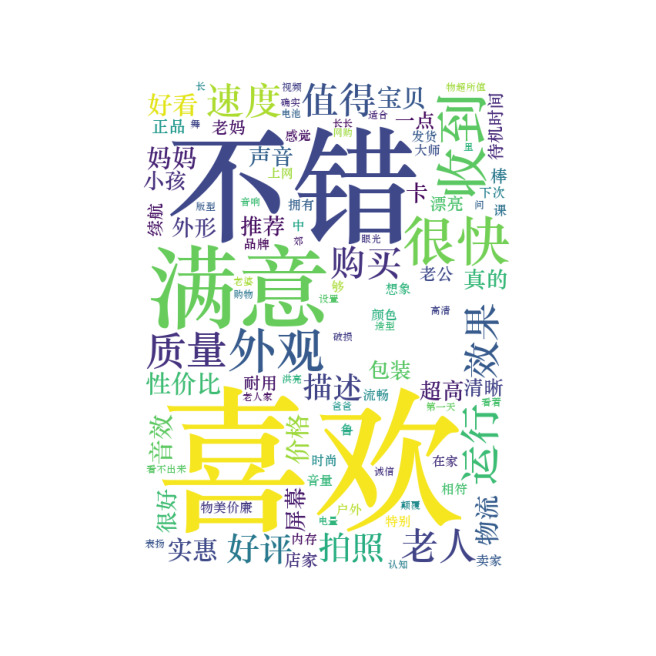

In [30]:
# 绘制正面情感词云
# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)

# 读取背景图片
background_image = Image.open('手机图片.jpg') # 图片路径
background_array = np.array(background_image)

wordcloud = WordCloud(font_path="C:/Windows/Fonts/STZHONGS.ttf",
                      max_words=100,
                      background_color='white',
                      prefer_horizontal=0.99#大部分都是横向排放
                      ,mask=background_array
                     )

# 设置matplotlib图像大小和分辨率
plt.figure(figsize=(6, 4), dpi=200)
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off') 
plt.show()

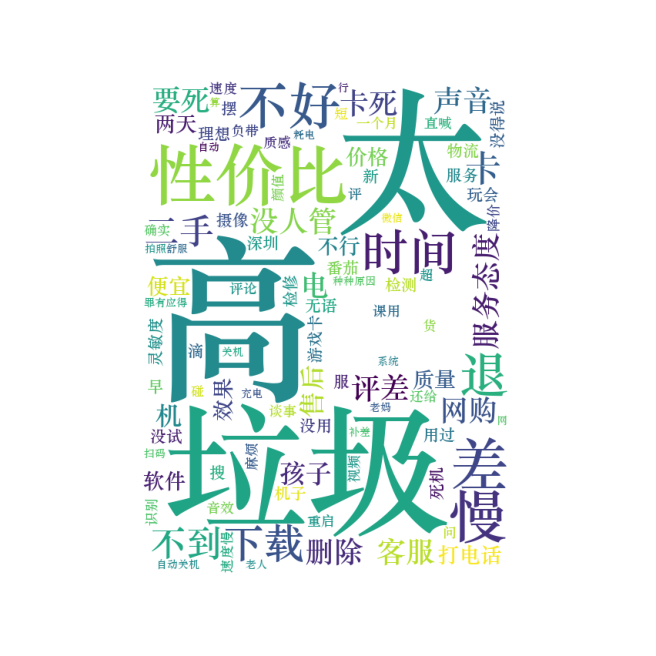

In [31]:
# 绘制负面评论词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
# 读取背景图片
background_image = Image.open('手机图片.jpg') # 图片路径
background_array = np.array(background_image)

wordcloud = WordCloud(font_path="C:/Windows/Fonts/STZHONGS.ttf",
                      max_words=100,
                      background_color='white',
                      prefer_horizontal=0.99#大部分都是横向排放
                      ,mask=background_array
                     )
neg_wordcloud = wordcloud.fit_words(freq_neg)
# 设置matplotlib图像大小和分辨率
plt.figure(figsize=(6, 4), dpi=200)
plt.imshow(neg_wordcloud)
plt.axis('off') 
plt.show()